### Working with dataset from 'The-Numbers.com'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile 
import sqlite3
%matplotlib inline
import seaborn as sns
from matplotlib import ticker

# import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

year_cutoff = 2012

In [2]:
#Load 'The Numbers' dataset
tn_df = pd.read_csv('../../data/tn.movie_budgets.csv.gz')
tn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


The dataset has no null values and includes columns for production_budget, domestic_gross and worldwide_gross however, they are all strings. First lets confirm that all numbers are dealing in the same currency ('$')

In [3]:
print("Is the production budget in dollars for all records?: ",tn_df['worldwide_gross'].str.startswith('$').sum() == len(tn_df))
print("Is the domestic gross in dollars for all records?: ",tn_df['domestic_gross'].str.startswith('$').sum() == len(tn_df))
print("Is the worldwide gross in dollars for all records?: ",tn_df['worldwide_gross'].str.startswith('$').sum() == len(tn_df))

Is the production budget in dollars for all records?:  True
Is the domestic gross in dollars for all records?:  True
Is the worldwide gross in dollars for all records?:  True


It looks all the business related data is in dollars. We can safely convert all the numbers without having to do any currency conversions. To ensure we don't lose track, a currency column is created to include the "$" symbol and all numbers are then proceeded to be converted to numbers

In [4]:
#Converting production buget, domestic gross, worldwide gross to numbers, Add currency unit column as a reminder 
#numbers are in $
tn_df['currency'] = '$'
tn_df['production_budget'] = tn_df['production_budget'].str.replace(',','').str.replace('$','').astype(int)
tn_df['domestic_gross'] = tn_df['domestic_gross'].str.replace(',','').str.replace('$','').astype(int)
tn_df['worldwide_gross'] = tn_df['worldwide_gross'].str.replace(',','').str.replace('$','').astype('int64')

Using these we can calculate the net revenue a movie generated

Note: Worldwide gross constitutes domestic gross. Therefore *Foreign Gross = World Wide Gross - Domestic Gross*

In [5]:
#Adding net revenue column and a foreign gross column
tn_df['foreign_gross'] = tn_df['worldwide_gross'] - tn_df['domestic_gross']
tn_df['net_revenue'] = tn_df['worldwide_gross'] - tn_df['production_budget']

Converting release_date to date time and appending month and year columns

In [6]:
tn_df['release_date'] = pd.to_datetime(tn_df['release_date'])
tn_df['release_year'] = tn_df['release_date'].dt.year
tn_df['release_month'] = tn_df['release_date'].dt.month

### Creating a unique key to allow cross referencing our different datasets
Multiple movies have the same title. Having a unique key that we can employ accross our datasets is (pardon the pun) key.
We will use this key to join/merge/search against. This will be a string comprising the movie title and the release year.

In [7]:
tn_df['key_ID'] = tn_df['movie'] + " ("+ tn_df['release_date'].dt.year.astype(str)+")"

Limiting data to post **Insert cut off year**
or essentially last 10 years worth of data. This will help us to emphasize more recent trends. 
For te purpose of visualization we will be using world wide earnings. Dropping records with no world wide earnings data

In [8]:
# Paring down the dataset by a cutoff year to ascertain more recent trends focusing on worldwide revenue
reduced_df = tn_df[tn_df['release_year']>=year_cutoff]
reduced_df_worldwide = reduced_df.drop(reduced_df[reduced_df['worldwide_gross']==0].index)

## Why should Microsoft get into movies?
Aside from owning IPs that lend itself to making good visual content, we can ascertain whether there is a business reason to get into movie making.Lets look at gross and net revenue performance of the box office by the year for the last 20 years

In [9]:
# Trend data for gross and net revenue across a time spread
trend_viz_df = tn_df[(tn_df['worldwide_gross']!=0)&(tn_df['net_revenue']!=0)] #remove entries with 0 for revenue and gross
trend_viz_df = trend_viz_df[(trend_viz_df['release_year']>=2000) & (trend_viz_df['release_year']<=2018)] #limit table release years
trend_viz_df = trend_viz_df.groupby('release_year').mean().reset_index() #get mean gross and revenue for each year

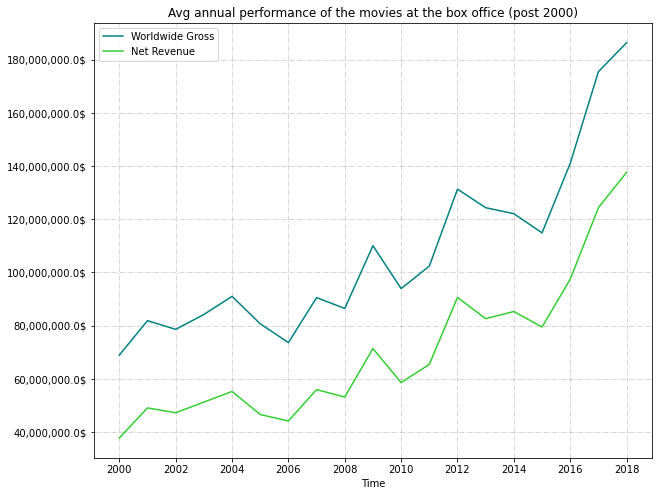

In [10]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(list(trend_viz_df['release_year']), list(trend_viz_df['worldwide_gross']),'teal')
ax.plot(list(trend_viz_df['release_year']), list(trend_viz_df['net_revenue']),'limegreen')

ax.set_xlabel('Time')
ax.set_xticks(np.arange(2000,2020,2))
ax.get_yaxis().set_major_formatter(ticker.StrMethodFormatter('{x:,}$'))

ax.set_title('Avg annual performance of the movies at the box office (post 2000)')
ax.legend(['Worldwide Gross','Net Revenue'])
ax.grid(c='k',ls= '-.',alpha = 0.2);

fig.savefig('../../images/AnnualMeanPerformance.jpg',
            transparent = False);

### Relationship between production budget and gross/net performance
Although a contributing factor, but not a strong positive corelation

**Drop this section**

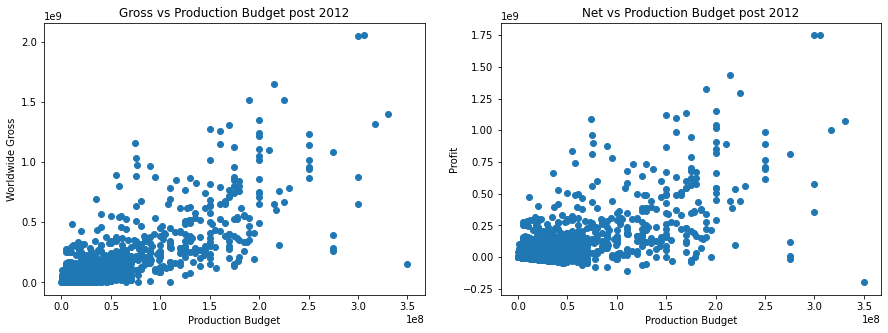

In [11]:
fig,ax = plt.subplots(1,2,figsize = (15,5))

ax[0].scatter(x = reduced_df_worldwide['production_budget'], 
              y = reduced_df_worldwide['worldwide_gross'])
ax[0].set_xlabel('Production Budget')
ax[0].set_ylabel('Worldwide Gross')
ax[0].set_title(f'Gross vs Production Budget post {year_cutoff}');

ax[1].scatter(x = reduced_df_worldwide['production_budget'], 
              y = reduced_df_worldwide['net_revenue'])
ax[1].set_xlabel('Production Budget')
ax[1].set_ylabel('Profit')
ax[1].set_title(f'Net vs Production Budget post {year_cutoff}');

### Best Release time of the year
Using the revenue data we can try to ascertain the best release windows for movies. From the last 10 years, we can see major revenue being generated during the summer season (May, June, July) and again during holiday season

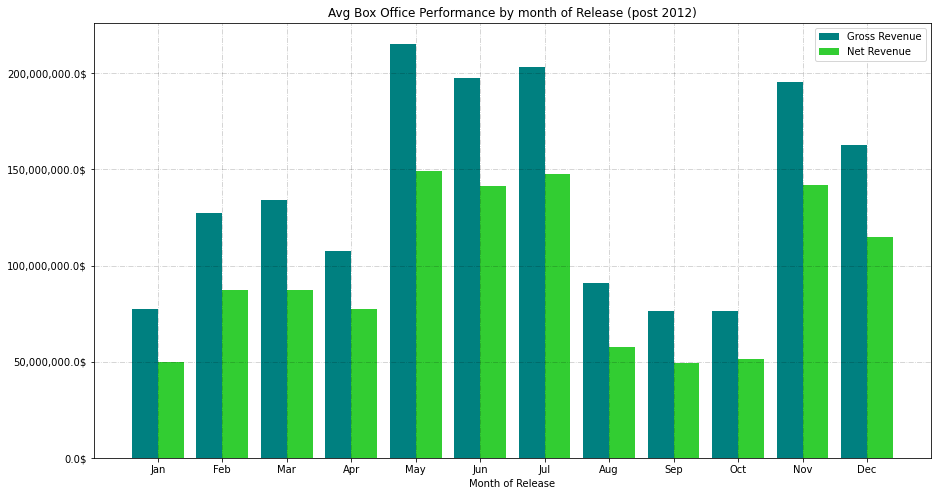

In [12]:
#Plot avg performance at the box office

fig,ax = plt.subplots(figsize = (15,8))

df = reduced_df_worldwide.groupby('release_month').mean()

#Graphs for mean gross/net revenue by the month
x = df['worldwide_gross'].index
w = 0.4

ax.set_title(f'Avg Box Office Performance by month of Release (post {year_cutoff})')

plt.xticks(ticks=[1,2,3,4,5,6,7,8,9,10,11,12],
           labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])

ax.bar(x-w/2, df['worldwide_gross'], w,color = 'teal')
ax.bar(x+w/2, df['net_revenue'], w,color = 'limegreen')

ax.set_xticks(np.arange(1,13,step=1))
ax.set_xlabel('Month of Release')

ax.get_yaxis().set_major_formatter(ticker.StrMethodFormatter('{x:,}$'))
ax.legend(['Gross Revenue', 'Net Revenue'])
ax.grid(c='k',ls= '-.',alpha = 0.2);

fig.savefig('../../images/MonthlyReleaseMeanPerformance.jpg',
            transparent = False);

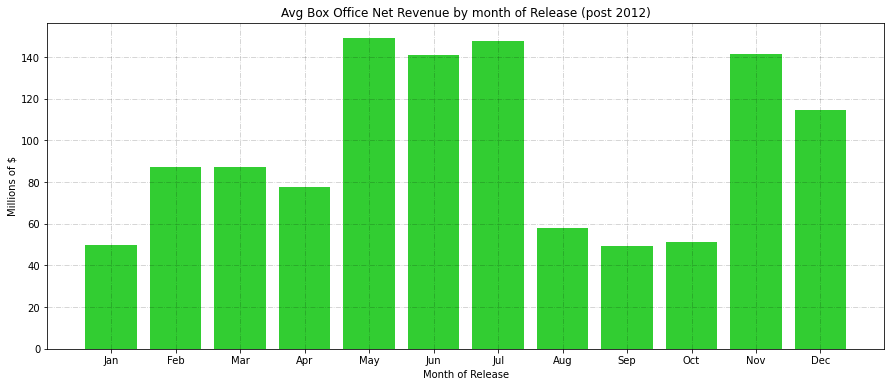

In [26]:
#Plot avg performance at the box office

fig,ax = plt.subplots(figsize = (15,6))
df = reduced_df_worldwide.groupby('release_month').mean()

ax.bar(df['worldwide_gross'].index, df['net_revenue']/1000000,color = 'limegreen')
ax.set_title(f'Avg Box Office Net Revenue by month of Release (post {year_cutoff})')
ax.set_xlabel('Month of Release')
ax.set_ylabel('Millions of $')
ax.grid(c='k',ls= '-.',alpha = 0.2)

plt.xticks(ticks=[1,2,3,4,5,6,7,8,9,10,11,12],
           labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])



ax.get_yaxis().set_major_formatter(ticker.StrMethodFormatter('{x:g}'));




fig.savefig('../../images/MonthlyReleaseMeanPerformance.jpg',
            transparent = False);

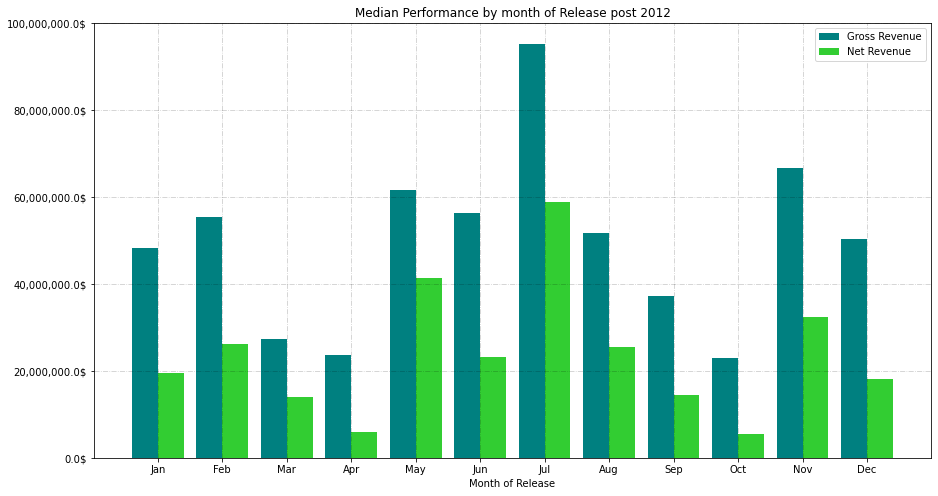

In [14]:
#Plot median performance at the box office

fig,ax = plt.subplots(figsize = (15,8))

df = reduced_df_worldwide.groupby('release_month').median()

#Graphs for median gross/net revenue by the month
x = df['worldwide_gross'].index
w = 0.4

ax.set_title(f'Median Performance by month of Release post {year_cutoff}')

ax.bar(x-w/2, df['worldwide_gross'], w,color = 'teal')
ax.bar(x+w/2, df['net_revenue'], w,color = 'limegreen')

plt.xticks(ticks=[1,2,3,4,5,6,7,8,9,10,11,12],
           labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
# ax.set_xticks(np.arange(1,13,step=1))
ax.set_xlabel('Month of Release')

ax.get_yaxis().set_major_formatter(ticker.StrMethodFormatter('{x:,}$'))
ax.legend(['Gross Revenue', 'Net Revenue'])
ax.grid(c='k',ls= '-.',alpha = 0.2);